### Oracle SQL Queries

#### average number of transit exceptions by carrier
SELECT *
FROM SO
WHERE so_id in (
SELECT DISTINCT(so_id)
FROM ST
WHERE tec IS NOT NULL and last_update_date BETWEEN to_date('01-JAN-2017') and to_date('31-AUG-2017'));

#### average number of late shipments by carrier 
select average, vendorname from (
select AVG(late_shipments / sc) average, vendorname from (
select count(distinct(so.so_id)) as sc, v.VENDOR_NAME vn, SUM(ti.late_flag) late_shipments
FROM soo so, vendor v, tracking_info ti
WHERE
(so.sd BETWEEN to_date('01-JAN-2017') and to_date('31-AUG-2017')) 
and so.vendor_id = v.vi 
and so.soo = ti.so_id
group by so.so_id, ti.late_flag, v.vn)
group by vendorname)
order by vendorname asc

#### average number of various transit codes by carrier
select average, vendorname, transitcode from (
select AVG(transitcodecount / shipmentcount) average, vendorname , transitcode  from  (
select count(st.tsc) as transitcodecount, count(distinct(so.so_id)) as shipmentcount,v.vn vendorname, st.TRANSIT_STATUS_CODE transitcode
FROM s_t st, soo so , vendor v
WHERE
(so.shipment_date BETWEEN to_date('01-JAN-2017') and to_date('31-AUG-2017'))
 and so.so_id = st.so_id
and so.vendor_id = v.vendor_id 
group by  so.shipment_order_id,ST.tsc , v.VENDOR_NAME)
group by vendorname, transitcode)
order by vendorname asc, transitcode asc

#### average price per shipment by carrier
select average, vendorname from (
select AVG(price_of_shipments / shipmentcount) average, vendorname from (
select count(distinct(so.SHIPMENT_ORDER_ID)) as shipmentcount, v.vn vendorname, SUM(i.due_amount) price_of_shipments
FROM soo_o so, vendor v, invoice_s i
WHERE
(so.shipment_date BETWEEN to_date('01-JAN-2017') and to_date('31-AUG-2017')) 
and so.vendor_id = v.vendor_id 
and so.so_id = i.so_id
group by so.so_id, i.due_amount, v.vn)
group by vendorname)
order by vendorname asc

### Imports 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import re
from sklearn.cluster import KMeans
%matplotlib inline

### Load in Data

In [2]:
avg_codes = pd.read_csv('/Users/chaserenick/cap/asl.csv')
avg_codes.columns = [c.lower().replace(".","_") for c in avg_codes.columns]

no_carrier_exception = pd.read_csv('/Users/chaserenick/cap/noex.csv')
no_carrier_exception.columns = [d.lower().replace(".","_") for d in no_carrier_exception.columns]

carrier_exception = pd.read_csv('/Users/chaserenick/cap/exc.csv')
carrier_exception.columns = [e.lower().replace(".","_") for e in carrier_exception.columns]

vendors = pd.read_csv("/Users/chaserenick/cap/v.csv")
vendors.columns = [f.lower().replace(".","_") for f in vendors.columns]

dollars = pd.read_csv('/Users/chaserenick/Desktop/cap/sp.csv')
dollars.columns = [g.lower().replace(".","_") for g in dollars.columns]

late = pd.read_csv('/Users/chaserenick/Desktop/cap/als.csv')
late.columns = [h.lower().replace(".","_") for h in late.columns]

//anaconda/envs/nlp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Rename columns

In [3]:
avg_codes.rename(columns={'average': 'average_transit_event', 'vendorname': 'vendor_svc_id'}, inplace=True)
dollars.rename(columns={'average': 'avg_dollars_per_shipment', 'vendorname': 'vendor_svc_id'}, inplace=True)
late.rename(columns={'average': 'avg_number_of_late_shipments', 'vendorname': 'vendor_svc_id'}, inplace=True)

### Functions

In [57]:
def df_to_vc_df(df,col_name,one_vc_col_name,second_vc_col_name):
    """
    INPUT: 
    df = A dataframe
    col_name = column name you want to be in the new value count data frame
    one_vc_col_name = Name of 1st new vc column
    second_vc_col_name = Name of 2nd new vc column
    
    OUTPUT: A value counts dataframe with your specified columns
    """
    new_df = df[str(col_name)].value_counts().to_frame().reset_index()
    new_df = new_df.rename(columns={'index':str(one_vc_col_name), str(col_name):str(second_vc_col_name)})
    
    return new_df


def give_vendor_descript(vc,vc_column,num):
    
    """
    INPUT: A value count object
    OUTPUT: A dataframe of either vendor_id with frequency or vendor_svc_id with frequency
    """
    
    if vc.columns[0] == 'vendor_id':
        ven_id = np.asarray(vc['vendor_id'].astype(int))[:num]
        fre_ven = np.asarray(vc.frequency.astype(int))[:num]
        carr = []
        for num in ven_id:
            description = (np.asarray(vendors[vendors['vendor_id']==num].vendor_name)[0])
            carr.append(description)

        new_offline_df = pd.DataFrame({'vendor_id':carr, 'frequency':fre_ven})
        columnsTitles=["vendor_id","frequency"]
        new_offline_df=new_offline_df.reindex(columns=columnsTitles)
    else:
        svc = np.asarray(vc['vendor_svc_id'].astype(int))[:num]
        freq_svc = np.asarray(vc.frequency.astype(int))[:num]
        carr = []
        for num in svc:
            description = (np.asarray(vendors[vendors['vendor_svc_id']==num].vendor_name)[0]), np.asarray(vendors[vendors['vendor_svc_id']== num].name)[0]
            vendor_n, detail = description
            vendor_n = str(vendor_n)
            detail = str(detail)
            joined = ' '.join([vendor_n,detail])
            carr.append(joined)

        new_offline_df = pd.DataFrame({'vendor_svc_id':carr, 'frequency':freq_svc})
        columnsTitles=["vendor_svc_id","frequency"]
        new_offline_df=new_offline_df.reindex(columns=columnsTitles)
    
    return new_offline_df


def change_to_svc(df,vendors_df):
    """
    INPUT: Dataframe and vendors dataframe
    OUTPUT: Dataframe of vendor_svc with string
    """
    
    svc = np.asarray(df['vendor_svc_id'].astype(int))
    carr = []
    for num in svc:
        description = (np.asarray(vendors_df[vendors_df['vendor_svc_id']==num].vendor_name)[0]), np.asarray(vendors_df[vendors_df['vendor_svc_id']== num].name)[0]
        vendor_n, detail = description
        vendor_n = str(vendor_n)
        detail = str(detail)
        joined = ' '.join([vendor_n,detail])
        carr.append(joined)
    
    # Find the name of the column by index
    n = df.columns[37]

    # Drop that column
    df.drop(n, axis = 1, inplace = True)

    # Put whatever series you want in its place
    df[n] = carr

    return df


def merge_frames(df1,df2,on_what):
    
    """
    INPUT: Dataframe 1, Dataframe 2, column to merge on
    OUTPUT: New merged dataframe 
    """
    
    new_df = pd.merge(df1, df2, how='outer', on=[str(on_what)])
    return new_df


def merge_transit_frames(df1,df2):
    """
    INPUT: Dataframe 1 and Dataframe 2 (merge is inner on vendor_id)
    OUPUT: Dataframe of transit exceptions and totals
    """

    new_df = pd.merge(df1, df2, how='outer', on=['vendor_svc_id'])
    new_df = new_df.fillna(0)
    new_df.columns = ['vendor_svc_id', 'transit_exceptions', 'no_transit_exceptions']
    new_df['total'] = new_df['transit_exceptions'] + new_df['no_transit_exceptions']
    new_df['percent_of_transit_exceptions'] = new_df['transit_exceptions']/new_df['total']
    new_df['percent_of_no_transit_exceptions'] = new_df['no_transit_exceptions']/new_df['total']

    percent_df = new_df[['vendor_svc_id','total','percent_of_transit_exceptions','percent_of_no_transit_exceptions']]
    percent_df = percent_df.sort_values(['total','percent_of_transit_exceptions'], ascending=[False,True])
    percent_df = new_df[['vendor_svc_id','percent_of_transit_exceptions','percent_of_no_transit_exceptions']]
    
    return new_df


def get_averages(df):
    """
    INPUT: Dataframe
    OUTPUT: List of pickup, intransit, delivered, and carrier_names
    """
    arvd = []
    arvp = []
    awat = []
    awcu = []
    cler = []
    conf = []
    crgod = []
    crgoo = []
    custd =[]
    custr = []
    delconf = []
    delia = []
    delivered = []
    dldk = []
    dlre = []
    dlva = []
    dptd = []
    dptp = []
    flghta = []
    flghtd = []
    intransit = []
    loaded = []
    loadst = []
    merch = []
    othrd = []
    outfrdly = []
    pickatmp = []
    pickedup = []
    pkd = []
    puap = []
    ret = []
    shipc = []
    shiph = []
    shpohd = []
    shipoho = []
    trail = []
    unloaded = []
    withdl = []

    carrier_name = []

    for vendor_name in set(df.vendor_svc_id):
        vendor = df[df['vendor_svc_id']== vendor_name]
        carrier_name.append(vendor_name)

        if 'ARVDLVLOC' in list(vendor.transitcode):
            arvd.append(list(vendor[vendor['transitcode']=='ARVDLVLOC'].average_transit_event)[0])
        else:
            arvd.append(0)

        if 'ARVPULOC' in list(vendor.transitcode):
            arvp.append(list(vendor[vendor['transitcode']=='ARVPULOC'].average_transit_event)[0])
        else:
            arvp.append(0)

        if 'AWATPICK' in list(vendor.transitcode):
            awat.append(list(vendor[vendor['transitcode']=='AWATPICK'].average_transit_event)[0])
        else:
            awat.append(0)

        if 'AWCUSCLR' in list(vendor.transitcode):
            awcu.append(list(vendor[vendor['transitcode']=='AWCUSCLR'].average_transit_event)[0])
        else:
            awcu.append(0)

        if 'CLERCUST' in list(vendor.transitcode):
            cler.append(list(vendor[vendor['transitcode']=='CLERCUST'].average_transit_event)[0])
        else:
            cler.append(0)

        if 'CONFBORD' in list(vendor.transitcode):
            conf.append(list(vendor[vendor['transitcode']=='CONFBORD'].average_transit_event)[0])
        else:
            conf.append(0)

        if 'CRGODMGD' in list(vendor.transitcode):
            crgod.append(list(vendor[vendor['transitcode']=='CRGODMGD'].average_transit_event)[0])
        else:
            crgod.append(0)

        if 'CRGOOFFL' in list(vendor.transitcode):
            crgoo.append(list(vendor[vendor['transitcode']=='CRGOOFFL'].average_transit_event)[0])
        else:
            crgoo.append(0)

        if 'CUSTDLAY' in list(vendor.transitcode):
            custd.append(list(vendor[vendor['transitcode']=='CUSTDLAY'].average_transit_event)[0])
        else:
            custd.append(0)

        if 'CUSTREL' in list(vendor.transitcode):
            custr.append(list(vendor[vendor['transitcode']=='CUSTREL'].average_transit_event)[0])
        else:
            custr.append(0)

        if 'DELCONF' in list(vendor.transitcode):
            delconf.append(list(vendor[vendor['transitcode']=='DELCONF'].average_transit_event)[0])
        else:
            delconf.append(0) 

        if 'DELIATMP' in list(vendor.transitcode):
            delia.append(list(vendor[vendor['transitcode'] == 'DELIATMP'].average_transit_event)[0])
        else:
            delia.append(0) 

        if 'DELIVRED' in list(vendor.transitcode):
            delivered.append(list(vendor[vendor['transitcode']=='DELIVRED'].average_transit_event)[0])
        else:
            delivered.append(0)

        if 'DLDKCLOS' in list(vendor.transitcode):
            dldk.append(list(vendor[vendor['transitcode']== 'DLDKCLOS'].average_transit_event)[0])
        else:
            dldk.append(0)

        if 'DLREFUSE' in list(vendor.transitcode):
            dlre.append(list(vendor[vendor['transitcode']== 'DLREFUSE'].average_transit_event)[0])
        else:
            dlre.append(0)

        if 'DLVAPTSCH' in list(vendor.transitcode):
            dlva.append(list(vendor[vendor['transitcode']== 'DLVAPTSCH'].average_transit_event)[0])
        else:
            dlva.append(0)

        if 'DPTDLVLOC' in list(vendor.transitcode):
            dptd.append(list(vendor[vendor['transitcode']== 'DPTDLVLOC'].average_transit_event)[0])
        else:
            dptd.append(0)

        if 'DPTPULOC' in list(vendor.transitcode):
            dptp.append(list(vendor[vendor['transitcode']== 'DPTPULOC'].average_transit_event)[0])
        else:
            dptp.append(0)

        if 'FLGHTARR' in list(vendor.transitcode):
            flghta.append(list(vendor[vendor['transitcode']== 'FLGHTARR'].average_transit_event)[0])
        else:
            flghta.append(0)

        if 'FLGHTDPT' in list(vendor.transitcode):
            flghtd.append(list(vendor[vendor['transitcode']== 'FLGHTDPT'].average_transit_event)[0])
        else:
            flghtd.append(0)  

        if 'INTRANST' in list(vendor.transitcode):
            intransit.append(list(vendor[vendor['transitcode']=='INTRANST'].average_transit_event)[0])
        else:
            intransit.append(0)

        if 'LOADED' in list(vendor.transitcode):
            loaded.append(list(vendor[vendor['transitcode']== 'LOADED'].average_transit_event)[0])
        else:
            loaded.append(0)

        if 'LOADSTART' in list(vendor.transitcode):
            loadst.append(list(vendor[vendor['transitcode']== 'LOADSTART'].average_transit_event)[0])
        else:
            loadst.append(0)

        if 'MECHDLAY' in list(vendor.transitcode):
            merch.append(list(vendor[vendor['transitcode']== 'MECHDLAY'].average_transit_event)[0])
        else:
            merch.append(0)

        if 'OTHRDLAY' in list(vendor.transitcode):
            othrd.append(list(vendor[vendor['transitcode']==  'OTHRDLAY'].average_transit_event)[0])
        else:
            othrd.append(0)

        if 'OUTFRDLY' in list(vendor.transitcode):
            outfrdly.append(list(vendor[vendor['transitcode']== 'OUTFRDLY'].average_transit_event)[0])
        else:
            outfrdly.append(0)

        if 'PICKATMP' in list(vendor.transitcode):
            pickatmp.append(list(vendor[vendor['transitcode']== 'PICKATMP'].average_transit_event)[0])
        else:
            pickatmp.append(0)

        if 'PICKEDUP' in list(vendor.transitcode):
            pickedup.append(list(vendor[vendor['transitcode']=='PICKEDUP'].average_transit_event)[0])
        else:
            pickedup.append(0)

        if 'PKDKCLOS' in list(vendor.transitcode):
            pkd.append(list(vendor[vendor['transitcode']==  'PKDKCLOS'].average_transit_event)[0])
        else:
            pkd.append(0)

        if 'PUAPTSCH' in list(vendor.transitcode):
            puap.append(list(vendor[vendor['transitcode']==  'PUAPTSCH'].average_transit_event)[0])
        else:
            puap.append(0)

        if 'RETSEND' in list(vendor.transitcode):
            ret.append(list(vendor[vendor['transitcode']==  'RETSEND'].average_transit_event)[0])
        else:
            ret.append(0)

        if 'SHIPCANC' in list(vendor.transitcode):
            shipc.append(list(vendor[vendor['transitcode'] == 'SHIPCANC'].average_transit_event)[0])
        else:
            shipc.append(0)

        if 'SHIPHOLD' in list(vendor.transitcode):
            shiph.append(list(vendor[vendor['transitcode'] == 'SHIPHOLD'].average_transit_event)[0])
        else:
            shiph.append(0)

        if 'SHPOHDST' in list(vendor.transitcode):
            shpohd.append(list(vendor[vendor['transitcode'] == 'SHPOHDST'].average_transit_event)[0])
        else:
            shpohd.append(0)

        if 'SHPOHORG' in list(vendor.transitcode):
            shipoho.append(list(vendor[vendor['transitcode'] == 'SHPOHORG'].average_transit_event)[0])
        else:
            shipoho.append(0)

        if 'TRAILDROP' in list(vendor.transitcode):
            trail.append(list(vendor[vendor['transitcode'] == 'TRAILDROP'].average_transit_event)[0])
        else:
            trail.append(0)

        if 'UNLOADED' in list(vendor.transitcode):
            unloaded.append(list(vendor[vendor['transitcode'] == 'UNLOADED'].average_transit_event)[0])
        else:
            unloaded.append(0)

        if 'WTHRDLAY' in list(vendor.transitcode):
            withdl.append(list(vendor[vendor['transitcode'] == 'WTHRDLAY'].average_transit_event)[0])
        else:
            withdl.append(0)

    return carrier_name, arvd, arvp, awat, awcu, cler, conf, crgod, crgoo, custd, custr, delconf, delia, delivered, dldk, dlre, dlva, dptd, dptp, flghta, flghtd, intransit, loaded, loadst, merch, othrd, outfrdly, pickatmp, pickedup, pkd, puap, ret, shipc, shiph, shpohd, shipoho, trail, unloaded, withdl  



def k_means_cluster(df,num_clusters):
    
    """
    INPUT: Dataframe and desired number of clusters
    OUTPUT: Labels and Centroids 
    """
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=111)
    kmeans.fit(df)
    
    labels = kmeans.predict(df)
    centroids = kmeans.cluster_centers_
    
    return labels, centroids


def make_arrays(df,label):
    """
    INPUT: Dataframe and predicted cluster labels
    OUTPUT: Arrays of all rows associated with that label"""
    
    l = []
    for i in range(len(df[df['labels']==label])):
        l.append(list(df[df['labels']==label].iloc[:, 0:3].iloc[i]))
    return np.asarray(l)

def group_vendors(df,labels):
    group_1 = []
    group_2 = []
    group_3 = []
    group_4 = []
    
    for i in range(len(labels)):
        if labels[i] == 0:
            group_1.append(list(df.vendor_svc_id)[i])
        if labels[i] == 1:
            group_2.append(list(df.vendor_svc_id)[i])
        if labels[i] == 2:
            group_3.append(list(df.vendor_svc_id)[i])
#         if labels[i] == 3:
#             group_4.append(list(df.vendor_svc_id)[i])
            
    return group_1, group_2, group_3


def pca_transformation(df):
    
    """
    INPUT: A dataframe
    OUTPUT: A normalized transformed dataframe in 3D space
    Uses Sklearn PCA builtin
    """
    
    from sklearn.decomposition import PCA as sklearnPCA
    from sklearn.preprocessing import normalize
    
    normalized_data = normalize(df)
    sklearn_pca = sklearnPCA(n_components=3)
    
    return sklearn_pca.fit_transform(normalized_data)

def cluster_dataframes(group1,group2,group3,pca_data):
    cluster_1 = []
    cluster_2 = []
    cluster_3 = []
    # cluster_4 = []

    for i in range(len(labels)):
        if labels[i] == 0:
            cluster_1.append(list(pca_data[i]))
        if labels[i] == 1:
            cluster_2.append(list(pca_data[i]))
        if labels[i] == 2:
            cluster_3.append(list(pca_data[i]))
    #     if labels[i] == 3:
    #         cluster_4.append(list(pca_df[i]))

    cluster_1 = np.asarray(cluster_1)
    cluster_2 = np.asarray(cluster_2)
    cluster_3 = np.asarray(cluster_3)

    return cluster_1, cluster_2, cluster_3


def elbow_plot(pca_values,clusters_to_check):
    """
    INPUT: PCA dimenstionality reduced values # of clusters you want to check a range over
    OUTPUT: An Elbow Plot to help you determine optimum number of clusters"""
    
    from sklearn.cluster import KMeans
    from sklearn import metrics
    from scipy.spatial.distance import cdist
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    # k means determine k
    distortions = []
    K = range(1,clusters_to_check+1)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(pca_values)
        kmeanModel.fit(pca_values)
        distortions.append(sum(np.min(cdist(pca_values, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / pca_values.shape[0])

    new_visual = {'distortions': distortions, 'clusters': K}
    new_vis = pd.DataFrame(data=new_visual)

    # Plot the elbow
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(7, 7))
    sns.pointplot(x='clusters', y='distortions', data=new_vis)
    sns.despine( left=False, bottom=False)
    ax.set_xlabel('Number of Clusters (k)', fontsize=14)
    ax.set_ylabel('Sum of Squared Errors (SSE)', fontsize =14)
    plt.title('Elbow Graph of k-clusters for All Transit Features', fontsize=15);
    

def three_d_projection(cluster_1,cluster_2,cluster_3,centroids):
    
    """
    INPUT: The three clusters, and the centroids
    OUTPUT: 3D cluster projection with matplotlib
    
    NOTE: This code was taken from sklearn and modified for this project:
    
    Author: Fran Navarro-Brull <http://CAChemE.org>
    This code is an snippet from the original Spanish article:
    OriginLab vs Python
    https://github.com/franktoffel/origin/
    LICENSE: MIT
    References and Python libraries used:
    ----------
    * matplotlib 1.4.3: http://matplotlib.org/contents.html
     DOI: 10.5281/zenodo.15423
    * NumPy 1.9.2 http://www.numpy.org/
    """

    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D



    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')

    # Point generation by using normal standard distribution
    # 3D plotting and its projection to xy plane

    z_offset = 3

    # Cluster of points #1
    # --------------------
    coordinates_c1 = centroids[0]   # center point of the cluster
    cluster1 = cluster_1 + coordinates_c1

    # Plotting 3D points
    # ax.plot(cluster1[:, 0], cluster1[:, 1], cluster1[:, 2],'bo', alpha=0.6, label='Cluster 1')
    # Plotting projection (notice that the Z coordinates are set to zero)
    ax.plot(cluster1[:, 0], cluster1[:, 1], np.zeros_like(cluster1[:, 2])+z_offset,'yo', label='Cluster 2')

    # Cluster of points #2
    # --------------------
    coordinates_c2 = centroids[1]  # center point of the cluster
    cluster2 = cluster_2 + coordinates_c2
    # Plotting 3D points
    # ax.plot(cluster2[:, 0], cluster2[:, 1], cluster2[:, 2],'ro', alpha=0.6, label='Cluster 2')
    # Plotting projection (notice that the Z coordinates are set to zero)
    ax.plot(cluster2[:, 0], cluster2[:, 1], np.zeros_like(cluster2[:, 2])+z_offset,'co', label='Cluster 1')

    # Cluster of points #3
    # --------------------
    coordinates_c3 = centroids[2]  # center point of the cluster
    cluster3 = cluster_3 + coordinates_c3
    # ax.plot(cluster3[:, 0], cluster3[:, 1], cluster3[:, 2],'go', alpha=0.6, label='Cluster 3')
    # Plotting projection (notice that the Z coordinates are set to zero)
    ax.plot(cluster3[:, 0], cluster3[:, 1], np.zeros_like(cluster3[:, 2])+z_offset,'ko', label='Cluster 0',)

    # Cluster of points #3
    # --------------------
    # coordinates_c4 = centroids[3]  # center point of the cluster
    # cluster4 = cluster_4 + coordinates_c4
    # # # ax.plot(cluster4[:, 0], cluster4[:, 1], cluster4[:, 2],'mo', alpha=0.6, label='Cluster 4')
    # # # Plotting projection (notice that the Z coordinates are set to zero)
    # ax.plot(cluster4[:, 0], cluster4[:, 1], np.zeros_like(cluster4[:, 2])+z_offset,'mo', label='Cluster 4')


    # Sphere surface #1
    # ------------------
    u1 = np.linspace(0, 2 * np.pi, 100)
    v1 = np.linspace(0, np.pi, 100)


    x_sphere_1 = .5   * np.outer(np.cos(u1), np.sin(v1)) + coordinates_c1[0] -.2
    y_sphere_1 = .5 * np.outer(np.sin(u1), np.sin(v1)) + coordinates_c1[1]
    z_sphere_1 = .5 * np.outer(np.ones(np.size(u1)), np.cos(v1)) + z_offset + coordinates_c1[2]
    ax.plot_surface(x_sphere_1, y_sphere_1, z_sphere_1,
                    rstride=10, cstride=10, linewidth=0.1, color='y', alpha=0.1)

    # # Sphere surface #2
    # # ------------------
    u2 = np.linspace(0, 2 * np.pi, 100)
    v2 = np.linspace(0, np.pi, 100)

    x_sphere_2 = .6 * np.outer(np.cos(u2), np.sin(v2)) + coordinates_c2[0] + .3
    y_sphere_2 = .6 * np.outer(np.sin(u2), np.sin(v2)) + coordinates_c2[1] 
    z_sphere_2 = .5 * np.outer(np.ones(np.size(u2)), np.cos(v2)) + z_offset +coordinates_c2[2] -.2
    ax.plot_surface(x_sphere_2, y_sphere_2, z_sphere_2,
                    rstride=10, cstride=10, linewidth=0.1, color='c', alpha=0.1)

    # # Sphere surface #3
    # # -----------------
    u3 = np.linspace(0, 2 * np.pi, 100)
    v3 = np.linspace(0, np.pi, 100)

    x_sphere_3 = .5 * np.outer(np.cos(u3), np.sin(v3)) + coordinates_c3[0] + .65
    y_sphere_3 = .5 * np.outer(np.sin(u3), np.sin(v3)) + coordinates_c3[1]
    z_sphere_3 = .6 * np.outer(np.ones(np.size(u3)), np.cos(v3)) + z_offset +coordinates_c3[2] + .2
    ax.plot_surface(x_sphere_3, y_sphere_3, z_sphere_3,
                    rstride=10, cstride=10, linewidth=0.1, color='k', alpha=0.1)

    # Limits of the 3D representation
    ax.set_xlim3d(-2.5, 2)
    ax.set_ylim3d(-1, 3)
    ax.set_zlim3d(-1, 3)


    # Labels for the legend
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')

    # Show legend
    ax.legend()

    plt.show()

    
def silhouette_graph(pca_data):
    """
    INPUT: PCA_Data
    OUTPUT: AMAZING Silhoutette Graphs and 2D projections
    
    (NOTE: This code aside from slight modifications was taken from sklearn: 
    http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
    """
    
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np

    X = pca_data
    range_n_clusters = [2, 3, 4]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for k-means clustering on carrier data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()
        
        
def peformance_df(list_of_groups):
    """
    INPUT: A list of dataframes from the clustered groups
    OUTPUT: A single dataframe that measure the performance of various columns with averages"""
    
    cols = ['arvd', 'arvp', 'awat', 'awcu', 'cler', 'conf', 'crgod', 'crgoo',
            'custd', 'custr', 'delconf', 'delia', 'delivered', 'dldk', 'dlre',
            'dlva', 'dptd', 'dptp', 'flghta', 'flghtd', 'intransit', 'loaded',
            'loadst', 'merch', 'othrd', 'outfrdly', 'pickatmp', 'pickedup', 'pkd',
            'puap', 'ret', 'shipc', 'shiph', 'shipoho', 'shpohd', 'trail',
            'unloaded', 'withdl', 'percent_of_transit_exceptions',
            'percent_of_no_transit_exceptions', 'avg_number_of_late_shipments']
    
    def column_average(group,cols):        
        df = group[cols]
        return list(df.mean())
    
    stacked = []
    for cluster in range(len(list_of_groups)):
        stacked.append((column_average(list_of_groups[cluster],cols)))

    new_df = pd.DataFrame(stacked)
    new_df.columns = cols
    new_df['clusters'] = ['cluster_1','cluster_2','cluster_3']

    columns = new_df.columns.tolist()
    columns = columns[-1:] + columns[:-1]
    new_df = new_df[columns]
    
    return new_df

## Preprocessing Data

In [5]:
exception = df_to_vc_df(carrier_exception,'vendor_svc_id','vendor_svc_id','frequency')
no_exception = df_to_vc_df(no_carrier_exception,'vendor_svc_id','vendor_svc_id','frequency')

In [6]:
transit_df = merge_transit_frames(exception, no_exception)

In [7]:
carrier_name, arvd, arvp, awat, awcu, cler, conf, crgod, crgoo, custd, custr, delconf, delia, delivered, dldk, dlre, dlva, dptd, dptp, flghta, flghtd, intransit, loaded, loadst, merch, othrd, outfrdly, pickatmp, pickedup, pkd, puap, ret, shipc, shiph, shpohd, shipoho, trail, unloaded, withdl = get_averages(avg_codes) 

In [8]:
d = {'vendor_svc_id': carrier_name,
     'arvd': arvd, 
     'arvp': arvp, 
     'awat': awat, 
     'awcu': awcu,
     'awcu': awcu,
     'cler': cler,
     'conf': conf,
     'crgod': crgod,
     'crgoo': crgoo,
     'custd': custd,
     'custr': custr,
     'delconf': delconf,
     'delia': delia,
     'delivered': delivered,
     'dldk': dldk,
     'dlre': dlre,
     'dlva': dlva,
     'dptd': dptd,
     'dptp': dptp,
     'flghta': flghta,
     'flghtd': flghtd,
     'intransit': intransit,
     'loaded': loaded,
     'loadst': loadst,
     'merch': merch,
     'othrd': othrd,
     'outfrdly': outfrdly,
     'pickatmp': pickatmp,
     'pickedup': pickedup,
     'pkd': pkd,
     'puap': puap,
     'ret': ret,
     'shipc': shipc,
     'shiph': shiph,
     'shpohd': shpohd,
     'shipoho': shipoho,
     'trail': trail,
     'unloaded': unloaded,
     'withdl': withdl
    }
avg_df = pd.DataFrame(data=d)

In [9]:
# Filling in NaN values for value dataset
dollars = dollars.fillna(0)

### Combining Various Carrier Performance Datasets

In [10]:
combined_df = merge_frames(avg_df,transit_df,'vendor_svc_id').sort_values(by='total', ascending=False)
combined_df = combined_df.fillna(0)
combined_df = merge_frames(combined_df,late,'vendor_svc_id')
# combined_df = merge_frames(combined_df,dollars, 'vendor_svc_id')
combined_df = combined_df.fillna(0)

#### Examine top 150 based on volume

In [11]:
combined_df = combined_df[:150]

#Examining apply string to service level 
combined_df = change_to_svc(combined_df,vendors)

In [12]:
#Reorganizing new dataframe for PCA

organized_df = combined_df[['arvd','arvp',
'awat',
'awcu',
'cler',
'conf' ,
'crgod' ,
'crgoo' ,
'custd' ,
'custr' ,
'delconf' ,
'delia',
'delivered' ,
'dldk' ,
'dlre' ,
'dlva' ,
'dptd' ,
'dptp' ,
'flghta' ,
'flghtd' ,
'intransit' ,
'loaded' ,
'loadst' ,
'merch' ,
'othrd' ,
'outfrdly' ,
'pickatmp' ,
'pickedup' ,
'pkd' ,
'puap' ,
'ret' ,
'shipc' ,
'shiph' ,
'shipoho' ,
'shpohd' ,
'trail' ,
'unloaded' ,
'withdl' ,
'percent_of_transit_exceptions' ,
'percent_of_no_transit_exceptions' ,
'avg_number_of_late_shipments']]

### Principal Component Analysis (PCA)

In [13]:
pca_data = pca_transformation(organized_df)

#### Labels and centroids for clustering

In [14]:
labels, centroids = k_means_cluster(pca_data,3)

### Selecting approprite # of clusters

#### Elbow Plot

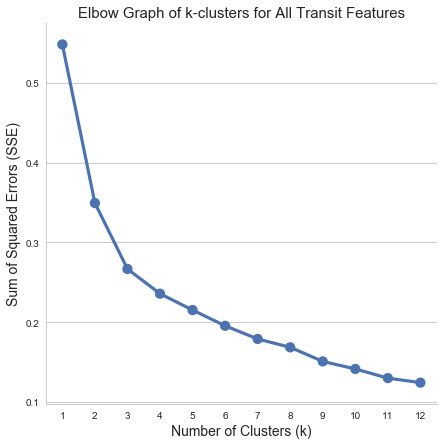

In [15]:
elbow_plot(pca_data,12)

#### Silhouette Score & Graph

For n_clusters = 2 The average silhouette_score is : 0.510071954058


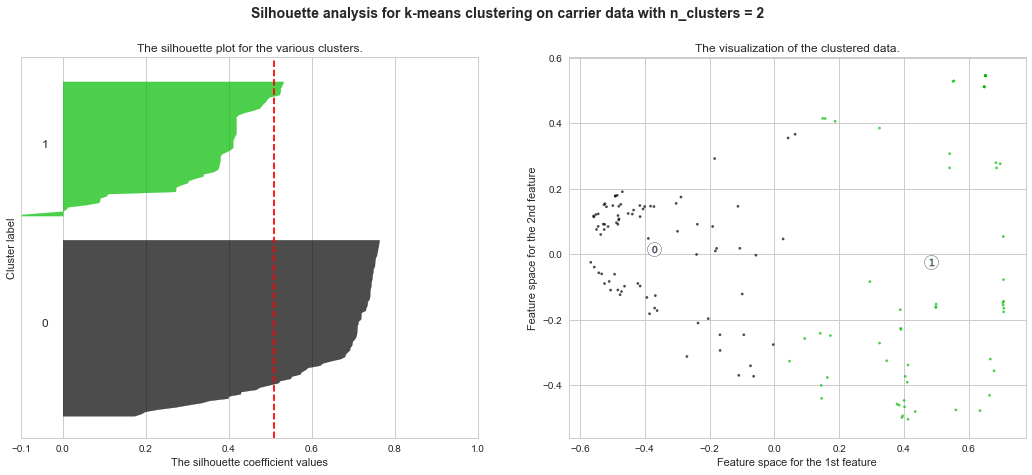

For n_clusters = 3 The average silhouette_score is : 0.549554706062


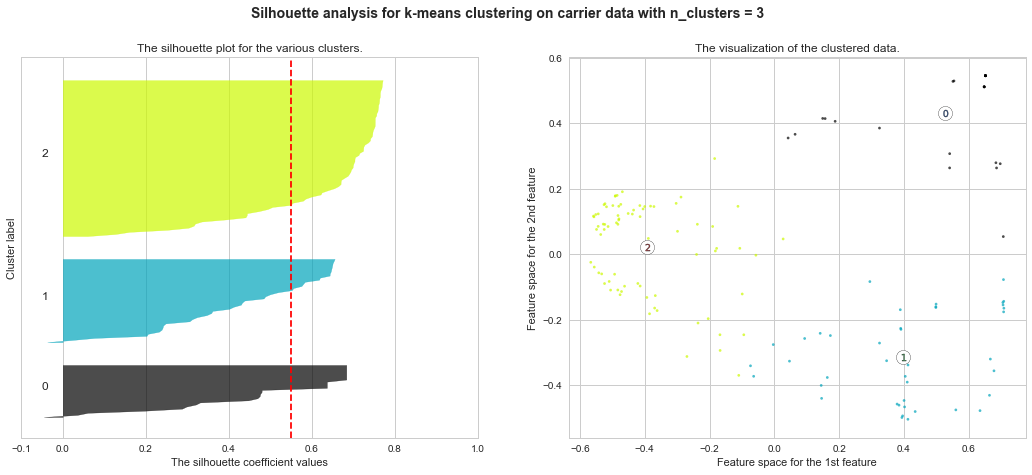

For n_clusters = 4 The average silhouette_score is : 0.508064033782


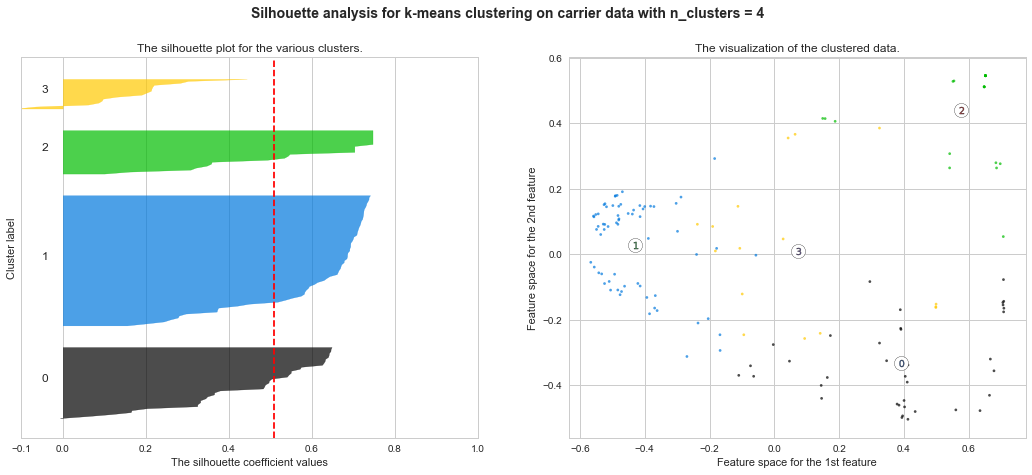

In [16]:
silhouette_graph(pca_data)

#### Grouping Clusters with Labels

In [17]:
group_1, group_2, group_3 = group_vendors(combined_df,labels)

#### Clustering Dataframes

In [18]:
cluster_1, cluster_2, cluster_3 = cluster_dataframes(group_1,group_2,group_3,pca_data)

#### 3D Cluster Projection 

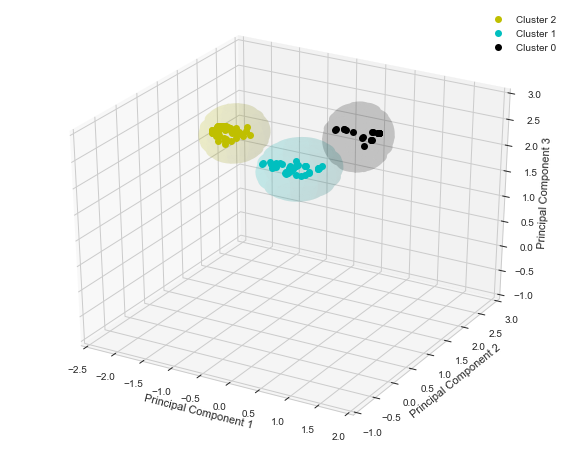

In [58]:
three_d_projection(cluster_1,cluster_2,cluster_3,centroids)

### Average Performance Across Clusters

In [20]:
group_1_df = combined_df.loc[combined_df['vendor_svc_id'].isin(group_1)]
group_2_df = combined_df.loc[combined_df['vendor_svc_id'].isin(group_2)]
group_3_df = combined_df.loc[combined_df['vendor_svc_id'].isin(group_3)]

new_list = [group_1_df,group_2_df,group_3_df]

cluster_per_df = peformance_df(new_list)

In [21]:
cluster_per_df.head()

,clusters,arvd,arvp,awat,awcu,cler,conf,crgod,crgoo,custd,...,shipc,shiph,shipoho,shpohd,trail,unloaded,withdl,percent_of_transit_exceptions,percent_of_no_transit_exceptions,avg_number_of_late_shipments
0,cluster_1,0.478541,0.510267,0.817952,0.06867,0.246505,0.0,0.0,0.0353,0.337386,...,0.304337,0.157618,0.039701,0.000000,0.171202,0.122525,0.177064,0.071466,0.928534,0.201705
1,cluster_2,0.799995,1.223882,0.243930,0.00000,0.000000,0.0,0.0,0.0000,0.024390,...,0.123965,0.000000,0.000000,0.000000,0.428244,0.000000,0.024390,0.004155,0.995845,0.331654
2,cluster_3,0.000000,0.154045,0.196083,0.00000,0.000000,0.0,0.0,0.0000,0.000000,...,0.000000,0.000000,0.088155,0.119168,0.000000,0.000000,0.000000,0.000000,1.000000,0.325457


#### Select a range to evaluate average performance

In [26]:
# cluster_per_df.loc[:, 'loaded':'avg_number_of_late_shipments']

### Carrier Performance Ranking

#### 1. Select appropriate service level from high performing cluster
#### 2. Select a performance metric(s)
#### 3. Select lowest cost within list of available carriers 
#### -> price engine can be integrated with clustering output to determine lowest price from location_1 to location_2

In [44]:
def best_performance(df, service_level, rank1, rank2, top_what):
    """
    INPUT: Clustered Dataframe, desired service level, feature 1, feature 2, top what 
    OUTPUT: String of carriers 
    """
    count = 0
    df = df.sort_values(by=[str(rank1),str(rank2)], ascending=[True,False])
    for name in df.vendor_svc_id:
        if count == top_what:
                break
        elif service_level in name:
            print (name)
            count += 1
        else:
            pass

In [45]:
best_performance(group_1_df, 'LTL', 'avg_number_of_late_shipments','intransit', 5)

Dayton Freight LTL 3 - 5 Days
Reddaway LTL 3 - 5 Days
SAIA LTL
UPS Freight Freight LTL
YRC LTL 3 -5 Day


In [39]:
group_1_df.sort_values(by=['avg_number_of_late_shipments','intransit'], ascending=[True,False]).head(3)

,arvd,arvp,awat,awcu,cler,conf,crgod,crgoo,custd,custr,...,trail,unloaded,withdl,transit_exceptions,no_transit_exceptions,total,percent_of_transit_exceptions,percent_of_no_transit_exceptions,avg_number_of_late_shipments,vendor_svc_id
57,0.00,0.000000,1.0,0.0,1.402886,0.0,0.0,0.000000,1.192308,0.0,...,0.0,0.0,0.0,250.0,1146.0,1396.0,0.179083,0.820917,0.0,FedEx Express International Economy Freight
117,1.15,1.051948,1.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,466.0,466.0,0.000000,1.000000,0.0,Coyote Logistics Van 48' - 53'
33,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,1.052402,0.000000,0.0,...,0.0,0.0,0.0,6.0,3227.0,3233.0,0.001856,0.998144,0.0,Dayton Freight LTL 3 - 5 Days
